<a href="https://colab.research.google.com/github/jincy-p-janardhanan/SPP-Pneumonia-Net/blob/deployment/SPP_Pneumonia_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies & Constants

Import dependencies

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import glob
import h5py
import math
import time
from tensorflow import keras
from tensorflow.python.client import device_lib
from random import shuffle
from sklearn.model_selection import train_test_split

In [4]:
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3824676650840237775
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6732761274709385580
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
2.6.0


Image shape parameters

In [5]:
input_height = 128
input_width = 128
n_channels = 1

Class labels

In [6]:
class_no=3
labels = {0:'Normal', 1:'Bacterial', 2:'Viral'}

To save models

In [7]:
model_path = '/content/drive/MyDrive/main_project/models/saved_model_'

# Last saved model number + 1 
model_count = 36

# Model Architecture

[Reference](https://github.com/SitiRaihanah/SPP-COVID-Net/blob/master/SPP-COVID-Net.py)

In [ ]:
def SPPPneumoniaNet(class_no,input_height,input_width): 
    # input_images=tf.keras.layers.Input(shape=(input_height,input_width,3))
    input_images=tf.keras.layers.Input(shape=(input_height,input_width,1))

    x = tf.keras.layers.Conv2D(8,(3,3),strides=(1,1),padding='same',use_bias=False)(input_images)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    x = tf.keras.layers.Conv2D(16,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #first triple
    x = tf.keras.layers.Conv2D(32,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(16,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(32,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #second triple
    x = tf.keras.layers.Conv2D(64,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(32,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #third triple
    x = tf.keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #fourth triple
    x = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    #ending network
    # L1 = tf.keras.layers.MaxPooling2D((7,7),strides=(1,1),padding='valid')(x)
    L1 = tf.keras.layers.MaxPooling2D((4,4),strides=(1,1),padding='valid')(x)
    # L2 = tf.keras.layers.MaxPooling2D((6,6),strides=(1,1),padding='valid')(x)
    L2 = tf.keras.layers.MaxPooling2D((4,4),strides=(1,1),padding='valid')(x)
    L3 = tf.keras.layers.MaxPooling2D((4,4),strides=(1,1),padding='valid')(x)

    FL1 = tf.keras.layers.Flatten()(L1)
    FL2 = tf.keras.layers.Flatten()(L2)
    FL3 = tf.keras.layers.Flatten()(L3)
    
    x = tf.keras.layers.Concatenate(axis=1)([FL1,FL2,FL3])
    
    x = tf.keras.layers.Dense(class_no,activation='softmax')(x)

    # Create model.
    model=tf.keras.models.Model(inputs=input_images,outputs=x)
    model.summary()

    return model

# Load Data

Load complete dataset from h5 file to arrays x and y

In [ ]:
dest_filepath = '/content/drive/MyDrive/main_project/dataseth5/complete_dataseth5_1.h5'

with h5py.File(dest_filepath, "r") as f:
    x = f["input_data"][:]
    y = f["input_labels"][:]
f.close()
print(x.shape)
x = np.reshape(x, (x.shape[0], 128, 128, 1))
print('x shape =', x.shape, '| y shape =', y.shape)

(8340, 16384)
x shape = (8340, 128, 128, 1) | y shape = (8340,)


## Preview Images

Plot some images from the dataset

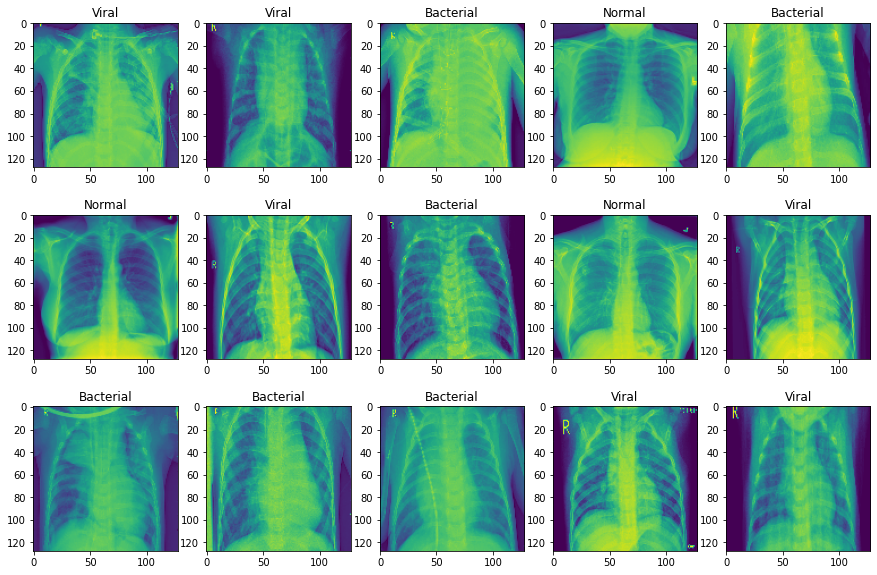

In [ ]:
plt.figure(figsize=(15,10))
for i in range(3):
    for j in range(5):
        idx = 5*i+j
        label_no = y[idx]
        plt.subplot(3,5,idx+1)
        im = np.squeeze(x[idx])
        plt.imshow(im)
        plt.title(labels[label_no])

# Model Training

## Train, Test Split

train and test split using h5file and sklearn <br>
[reference](https://www.machinecurve.com/index.php/2020/11/16/how-to-easily-create-a-train-test-split-for-your-machine-learning-model/)

> Shuffling (i.e. randomly drawing) samples is applied as part of the fit. Using a random_state, we can seed the random number generator to make its behavior replicable.

In [ ]:
random_state = 33
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=random_state)
print(y_train.shape)
y_train = tf.keras.utils.to_categorical(y_train, 3)
print(y_train.shape)
y_test = tf.keras.utils.to_categorical(y_test, 3)
print('train size: ', len(y_train), '\t test size: ', len(y_test))

(7089,)
(7089, 3)
train size:  7089 	 test size:  1251


## Create Model

Learning rate scheduler for exponential weight decay

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=900,
    decay_rate=0.95)

Create and compile model

In [ ]:
model=SPPPneumoniaNet(class_no,input_height,input_width)
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=lr_schedule, rho=0.80, epsilon=1e-07),
    loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training

### Train Model

In [ ]:
## Train model
epoch_no=10
print('Training')
H=model.fit(x=x_train,y=y_train,epochs=epoch_no,batch_size=4,verbose=2)

Training
Epoch 1/10
1773/1773 - 51s - loss: 0.8010 - accuracy: 0.6208
Epoch 2/10
1773/1773 - 18s - loss: 0.6042 - accuracy: 0.7294
Epoch 3/10
1773/1773 - 18s - loss: 0.5317 - accuracy: 0.7713
Epoch 4/10
1773/1773 - 18s - loss: 0.4800 - accuracy: 0.7894
Epoch 5/10
1773/1773 - 18s - loss: 0.4565 - accuracy: 0.8041
Epoch 6/10
1773/1773 - 18s - loss: 0.4364 - accuracy: 0.8172
Epoch 7/10
1773/1773 - 18s - loss: 0.4111 - accuracy: 0.8245
Epoch 8/10
1773/1773 - 18s - loss: 0.4042 - accuracy: 0.8261
Epoch 9/10
1773/1773 - 18s - loss: 0.3850 - accuracy: 0.8378
Epoch 10/10
1773/1773 - 18s - loss: 0.3739 - accuracy: 0.8444


#### Plot Accuracy and Loss

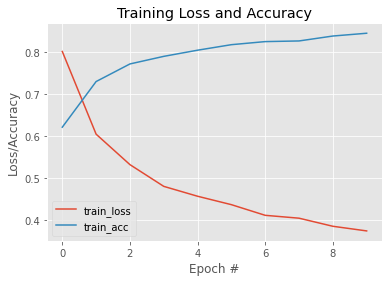

In [ ]:
N = np.arange(0, epoch_no)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show(block=False)
tf.keras.backend.clear_session()

### Test Model

In [ ]:
print('\n\nTesting')
loss,acc=model.evaluate(x_test, y_test, batch_size=1,verbose=2)
print("Test loss: ", loss, "Test accuracy:",acc)



Testing
1251/1251 - 5s - loss: 0.4122 - accuracy: 0.8297
Test loss:  0.41224026679992676 Test accuracy: 0.8297362327575684


### Save Model

In [ ]:
model.save(filepath= model_path+str(model_count))
model_count+=1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/main_project/models/saved_model_36/assets


# Prediction

Load saved model with best accuracy

In [12]:
saved_model_dir = '/content/drive/MyDrive/main_project/models/saved_model_11'

In [13]:
restored_model = keras.models.load_model(saved_model_dir)

Load and transform image

In [ ]:
test_image_path = '/content/drive/MyDrive/main_project/Viral/Viral Pneumonia-10.png'

In [ ]:
img = cv2.imread(test_image_path)
img = cv2.resize(img, (input_height, input_width), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # To convert colormap from BGR to GRAY
#Normalize the image - convert the each pixel value between 0 and 1
img = img / 255
img = np.reshape(img, (1, input_height, input_width, n_channels))

Predict result

In [ ]:
prediction = restored_model.predict(img)
result = labels[np.argmax(prediction)]
print(result)

Viral


# Deployment

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(restored_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp7vdikrx1/assets


In [15]:
with open('/content/drive/MyDrive/main_project/tflite/model.tflite', 'wb') as f:
  f.write(tflite_model)